TFIM
1. SA と 分割時間 Tcut tfim_sa_tcut_n6

In [4]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import lru_cache
import requests
# 通知設定
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1439055708988375082/6iiXA8J_3Bn1RPWZ8XmPfmfSJp_PkGdaIzt495Ao2fbu_a09VnMJpxmrnSyfN4Wtyc7T"
def notify_discord(message: str):
    payload = {"content": message}
    try:
        r = requests.post(DISCORD_WEBHOOK_URL, json=payload, timeout=5)
        r.raise_for_status()
        print("✅ Discord 通知送信 OK")
    except Exception as e:
        print("⚠ Discord 通知に失敗:", e)

# グラフ設定
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

markers = ['o', 's', '^', 'v', 'D', '*', '+', 'x']
colors = [
    "black",
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:red",
    "tab:brown",
    "tab:gray",
]
OUTDIR = Path("charts")
def save_fig(fig, stem: str):
    fig.savefig(OUTDIR / f"{stem}.pdf", bbox_inches="tight", dpi=300) 
    print(f"saved: {OUTDIR / (stem + '.pdf')}")

# データ保存
DATADIR = Path("data")

# データ読み込み例
# fname = DATADIR / "square_sa_tcut.npz" 

# dat = np.load(fname)

# N_list  = dat["N"]   # shape (nN,)
# hx_list = dat["hx_list"]  # shape (nHx,)
# Tcut_list = dat["Tcut"]
# EE      = dat["EE"]       # shape (nN, nHx)

In [23]:
# ========= キャッシュ付きヘルパ =========
@lru_cache(maxsize=None)
def get_ops(N):
    """Nだけで決まる演算子たち"""
    cut_pos = N // 2 - 1
    sx, sz = [0.5 * M for M in (qt.sigmax(), qt.sigmaz())]
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):
        return Sz[i] * Sz[i+1]

    Hcut_unit   = H_exchange(cut_pos)
    Hex_rest_unit = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    Hhx_unit    = sum(Sx[i] for i in range(N))

    left_sites = list(range(N//2))
    return Hcut_unit, Hex_rest_unit, Hhx_unit, left_sites

def simulate(N, J, hx, Tcut):
    """J, hx, Tcutだけで決まるもの"""
    Hcut_unit, Hex_rest_unit, Hhx_unit, left_sites = get_ops(N)

    H_full   = -J * (Hex_rest_unit + Hcut_unit) - hx * Hhx_unit
    # t>=Tcut のときのハミルトニアン（切断後）
    H_static = -J * Hex_rest_unit - hx * Hhx_unit

    def ramp(t, T_cut):
        if T_cut == 0.0:
            # 瞬時切断：t<=0で1, t>0で0（t=0 から見れば状態は変わらない）
            return 1.0 if t <= 0.0 else 0.0
        if t <= 0.0:
            return 1.0
        if t >= T_cut:
            return 0.0
        return 1.0 - t / T_cut

    Ht = [H_static, [-J * Hcut_unit, lambda t, args: ramp(t, Tcut)]]

    E0, psi0 = H_full.groundstate(sparse=True)

    if Tcut > 0.0:
        tlist = [0.0, float(Tcut)]
    else:
        tlist = [0.0]

    opts = {
        "method": "bdf",
        "nsteps": 100_000_000,
        "rtol": 1e-6,
        "atol": 1e-8,
        "max_step": (Tcut / 500.0) if Tcut > 0.0 else 0.1,
        "store_states": True,
        "progress_bar": None,
    }

    res = qt.sesolve(Ht, psi0, tlist, e_ops=[], options=opts)
    psi_T = res.states[-1]

    rhoL = qt.ptrace(psi_T, left_sites)
    return float(qt.entropy_vn(rhoL, base=2))


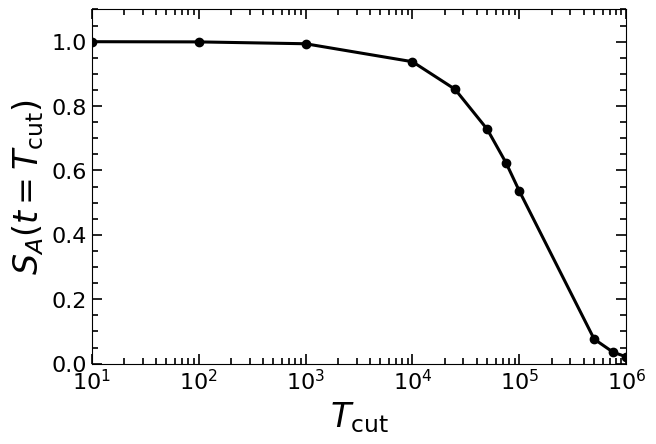

✅ Discord 通知送信 OK
saved: charts/tfim_sa_tcut_n6.pdf


In [34]:
# 1 基底状態のSA と 横磁場 hx
N_list = [6]
J = 1.0
hx = 0.067
Tcut_list =  [10, 100, 1000, 10000, 25000, 50000, 75000, 100000, 500000, 750000, 1000000]

for i, N in enumerate(N_list):
    fig, ax = plt.subplots(figsize=(6.9, 4.6))
    inward_ticks(ax)
    SA_list = [simulate(N=N, J=J, hx=hx, Tcut=Tcut) for Tcut in Tcut_list]
    ax.plot(
        Tcut_list,
        SA_list,
        marker=markers[0],
        color=colors[0],
        markersize=6.0,
    )
    
    ax.set_xscale("log") 
    ax.set_xlim(10.0, 1000000)
    ax.set_xlabel(r"$T_\mathrm{cut}$", fontsize=24)
    ax.set_ylim(0.0, 1.1)
    ax.set_ylabel(r"$S_A (t = T_\mathrm{cut})$", fontsize=24)
    
    plt.show()

    # データ保存
    npz_path = DATADIR / f"tfim_sa_tcut_n{N}.npz"
    np.savez(
        npz_path,
        N = N,
        Tcut_list=Tcut_list,
        SA_list=SA_list,
    )
    
    notify_discord(message=f"tifm sim 4 done")
    # グラフ保存
    save_fig(fig=fig, stem=f"tfim_sa_tcut_n{N}")

6


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

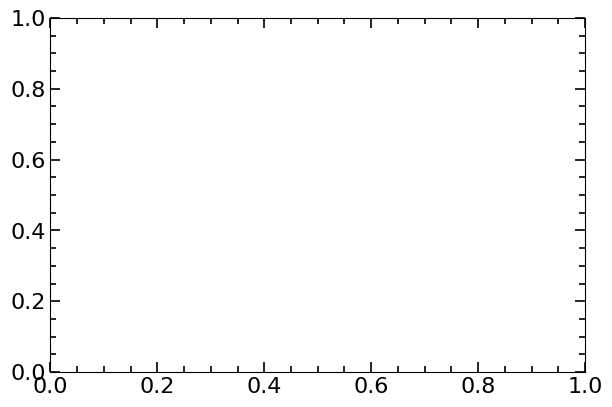

In [38]:
# 1 基底状態のSA と 横磁場 hx
N_list = [6, 4, 8]
J = 1.0
hx = 0.067
Tcut_list =  [10, 100, 1000, 10000, 25000, 50000, 75000, 100000, 500000, 7500000, 1000000]

for i, N in enumerate(N_list):
    fig, ax = plt.subplots(figsize=(6.9, 4.6))
    inward_ticks(ax)
    print(N)
    SA_list = [simulate(N=N, J=J, hx=hx, Tcut=Tcut) for Tcut in Tcut_list]
    ax.plot(
        Tcut_list,
        SA_list,
        marker=markers[i],
        color=colors[i],
        markersize=6.0,
    )
    
ax.set_xscale("log") 
ax.set_xlim(10.0, 1000000)
ax.set_xlabel(r"$T_\mathrm{cut}$", fontsize=24)
ax.set_ylim(0.0, 1.1)
ax.set_ylabel(r"$S_A (t = T_\mathrm{cut})$", fontsize=24)

plt.show()

nstamp = '-'.join(map(N_list, str))
notify_discord(message=f"tifm sim 5 done")
# グラフ保存
save_fig(fig=fig, stem=f"tfim_sa_tcut_n{nstamp}")